# Estimation of exchange interactions
Author: [Takuya Nomoto](mailto:nomoto@ap.t.u-tokyo.ac.jp)

## Liechtenstein method

The Liechtenstein method is a method for deriving the classical spin models from the itinerant electron models. Initially developed by Liechtenstein et al.[1] in the framework of the spin density functional theory, the method has been applied to various systems and is successful in understanding many magnetic behaviors, including finite temperature effects and long-period magnetic structures, which are not accessible from the spin density functional theory alone. Here, as the simplest case, we will see the formulation for the single-orbital model, where we can use the sparse_ir library to accelerate the calculations.

#### Liechtenstein formula in single-orbital model
Let us consider to derive exchange interactions from the following one-body Hamiltonian:

$$
\begin{align}
H=-t\sum_{<i,j>}\sum_s c^\dagger_{is} c_{js} - \sum_i \sum_{ss'} c^\dagger_{is} (\boldsymbol{B_i} \cdot \boldsymbol{\sigma}_{ss'}) c_{is'}
\end{align}
$$

If we set the effective magnetic field $\boldsymbol{B}_i$ to $\boldsymbol{B}_i=JS\boldsymbol{e}_i/2$, this is a classical Kondo lattice model, while if $\boldsymbol{B}_i=U\boldsymbol{m}_i/2$, this is a Hubbard model with the mean-field approximation. The basic idea of the Liechtenstein method is to impose the equivalence of the spin-angle-derivatives of the total energies in the itinerant systems and the classical spin systems. Note that the derivatives generally depend on a reference magnetic structure. Here, let us consider the classical Heisenberg model $E=-2\sum_{<i,j>}J_{ij}\boldsymbol{e}_i\cdot \boldsymbol{e}_j$ as a spin model and the $\hat{z}$-polarized ferromagnetic state (namely, $\boldsymbol{B_i}=B\hat{z}$) as a reference magnetic structure. Then, we will get

$$
\begin{align}
J_{ij} = -B^2T\sum_{\omega_n} G_{ij,+}(i\omega_n)G_{ji ,-}(i\omega_n)
\end{align}
$$

where the Green function $G_{ij,\sigma}(i\omega_n)$ is a Fourier transform of $G_{\boldsymbol{k},\sigma}(i\omega_n) = [i\omega_n - (\varepsilon_{\boldsymbol{k}}-B\sigma-\mu)]^{-1}$ with the single-particle dispersion $\varepsilon_{\boldsymbol{k}}$ and chemical potential $\mu$. $i\omega_n=(2n+1)\pi T$ is the Matsubara frequency and $\boldsymbol{k}$ is the crystal momentum. An important quantity here is defined by $J_0=\sum_{0\neq i}J_{0i}$, which is related to the mean-filed transition temperature $T_c^{\rm mf}$ in the classical Heisenberg model by $T_c^{\rm mf}=2J_0/3$. This can be evaluated from the above $J_{ij}$, or the direct comparison of the second derivatives of the total energy, which gives 

$$
\begin{align}
J_0 = \frac{B}{2} (n_{0,+}- n_{0,-})+ B^2T\sum_{\omega_n} G_{00,+}(i\omega_n)G_{00,-}(i\omega_n)
\end{align}
$$

In practice, $G_{00,\sigma}(i\omega_n)$ can be obtained by the $\boldsymbol{k}$ summation of $G_{\boldsymbol{k},\sigma}(i\omega_n)$ since all sites are equivalent in this model. Thus, the number of operations is $\mathcal{O}(N_M N_k^{tot})$ where $N_M$ is the number of Matsubara frequency and $N_k^{tot}$ is the total number of k-points. Since the typical value of $N_M$ is $N_M\sim \beta W$, the total cost is given by $\mathcal{O}(\beta W  N_k)$. On the other hand, we need $G_{ij,+}(i\omega_n)$ to evaluate $J_{ij}$, and in this case, the number of operations becomes $\mathcal{O}(N_M (N_k\ln N_k)^d)$ since the Fourier transform requires $N_k\ln N_k$ operations for a single axis, where $N_k$ is the number of k-points for a single axis and $d$ is the dimension. Thus, we need $\mathcal{O}(\beta W (N_k\ln N_k)^d)$ in total.

#### Sparse_ir
Since $G_{ij,\sigma}(i\omega_n)$ as well as $G_{00,\sigma}(i\omega_n)$ are just linear conbinations of $G_{\boldsymbol{k},\sigma}(i\omega_n)$, all terms we need take the following form,

$$
\begin{align}
\frac{1}{i\omega_n - \varepsilon_a}\frac{1}{i\omega_n - \varepsilon_b}=\frac{1}{\varepsilon_a-\varepsilon_b}\left(\frac{1}{i\omega_n - \varepsilon_a}-\frac{1}{i\omega_n - \varepsilon_b} \right)
\end{align}
$$

Thus, we can expand $G_{ij,+}(i\omega_n)G_{ji ,-}(i\omega_n)$ in the expression for $J_{ij}$ and $G_{00,+}(i\omega_n)G_{00,-}(i\omega_n)$ for $J_{0}$ by the intermadiate representation. Since the summation over $i\omega_n$ is equivalent to evaluating the Fourier transform at $\tau=0$, we need only $\mathcal{O}(\ln (\beta W))$ operations for the Matsubara frequancy axis. Thus, the computational cost becomes $\mathcal{O}(\ln(\beta W)  N_k^{tot})$ for $J_0$ and $\mathcal{O}(\ln(\beta W) (N_k\ln N_k)^d)$ for $J_{ij}$.

## Code implementation
Here, let us see an example code in a square lattice tight-binding model with dispersion $\varepsilon_{\boldsymbol{k}} = -2t\,[\cos(k_x) + \cos(k_y)]$. First, we load all necessary modules that we need:

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import sparse_ir

#### Parameter setting
The parameters to define the system are as follows; $t$: the nearest-neighbor hopping amplitude, $\beta$:  the inverse temperature, $N_k$: the numer of k-poitns for a single-axis and $B$: the strengh of the effective magnetic field.

In [2]:
t = 1 # means the bandwidth W is W=8t in a square lattice model
beta = 50 # inverse temperature
nk = 36 # number of k-points for a signle-axis
b_eff = 3 # strength of the effective magnetic field

#### Liechtenstein solver
This class contains two solvers, j0_calc for calculation of $J_{0}$ and jij_calc for $J_{ij}$. Both can be called after instantiating the class.

In [3]:
class liechtenstein:
  def __init__(self, basis, *args):
    # constructor of liechtenstein class
    # the class requires five arguments: sparse_ir basis object, t, beta, nk, and b_eff
    
    self.basis, self.M, self.T = basis, sparse_ir.MatsubaraSampling(basis), sparse_ir.TauSampling(basis)
    t, self.beta, self.nk, self.b_eff= args[0], args[1], args[2], args[3]
    k1, k2 = np.meshgrid(np.arange(self.nk)/self.nk, np.arange(self.nk)/self.nk, indexing='ij')
    self.ek = -2* t * (np.cos(2*np.pi*k1) + np.cos(2*np.pi*k2))
    self.nkt = self.nk**2

  def j0_calc(self, e_range=np.zeros(1), NM=None):
    # solver to evaluate J_0
    # e_range: numpy ndarray object to specify the chemical potentials at which we evaluate J_0
    # NM: maximum number of Matsubara frequency. if None, sparse sampling will be used
  
    # set Matsubara frequency grid
    if NM is None: iw = 1j*np.pi*self.M.sampling_points/self.beta
    else         : iw = 1j*np.pi*(2*np.arange(-NM,NM)+1)/self.beta

    # calculate the first term in the expresson of J_0
    n_up = .5 * (1-np.tanh(.5*self.beta*(self.ek[None,:,:]-e_range[:,None,None]-self.b_eff)))
    n_dn = .5 * (1-np.tanh(.5*self.beta*(self.ek[None,:,:]-e_range[:,None,None]+self.b_eff)))
    j0_1 = .5 * self.b_eff * np.mean(n_up - n_dn, axis=(1,2))
        
    # calculate the second term in the expression of J_0 as a function of iw 
    gkio_up = 1/(iw[:,None,None,None] - (self.ek[None,None,:,:]-self.b_eff-e_range[None,:,None,None]))
    gkio_dn = 1/(iw[:,None,None,None] - (self.ek[None,None,:,:]+self.b_eff-e_range[None,:,None,None]))
    gio_up = np.mean(gkio_up, axis=(2,3))
    gio_dn = np.mean(gkio_dn, axis=(2,3))
    j0_2_w = self.b_eff**2 * gio_up * gio_dn
    
    # evaluate a summation over iw 
    if NM is None:
      j0_2_l = self.M.fit(j0_2_w.reshape(len(iw),len(e_range))) # transform to the intermediate representation
      j0_2 = self.basis.u(0)@j0_2_l # evaluate the function at \tau=0
    else:
      j0_2 = np.sum(j0_2_w,axis=0)/self.beta
    
    # sum up the two terms
    self.j0 = np.real(j0_1 + j0_2)
    self.j0_e_range = e_range

  def jij_calc(self, mu=0, NM=None):
    # solver to evaluate J_ij
    # mu: the chemical potential at which we evaluate J_ij
    # NM: maximum number of Matsubara frequency. if None, sparse sampling will be used
    
    # set Matsubara frequency grid
    if NM is None: iw = 1j*np.pi*self.M.sampling_points/self.beta
    else         : iw = 1j*np.pi*(2*np.arange(-NM,NM)+1)/self.beta
        
    # calculate J_ij as a function of iw 
    gkio_up = 1/(iw[:,None,None] - (self.ek[None,:,:]-self.b_eff-mu))
    gkio_dn = 1/(iw[:,None,None] - (self.ek[None,:,:]+self.b_eff-mu))
    grio_up = np.fft.fftn(gkio_up,axes=(1,2))/self.nkt
    grio_dn = np.fft.ifftn(gkio_dn,axes=(1,2))
    jij_w = - self.b_eff**2 * grio_up * grio_dn
    
    # evaluate a summation of J_ij over iw 
    if NM is None:
      jij_l = self.M.fit(jij_w.reshape(len(iw),self.nkt))
      jij = self.basis.u(0)@jij_l
    else:
      jij = np.sum(jij_w,axis=0)/self.beta
    
    # arrange the format to ouput the data
    self.jij = np.real(jij)
    self.jij[0] = 0
    self.jij_r = np.linalg.norm(np.array(np.meshgrid(np.arange(self.nk),np.arange(self.nk), indexing='ij')), axis=0).flatten()

#### Instantiation 
In the instantation, we have to pass a sparse_ir.basis object as the first argument of the liechtenstein class.

In [4]:
Lambda = 2*max(8*t, b_eff) * beta
basis = sparse_ir.FiniteTempBasis(statistics='F', beta=beta, wmax=Lambda, eps=1e-7)
l = liechtenstein(basis, t, beta, nk, b_eff)

#### Executing the solver for J_0
Here, let us evaluate J_0 as a function of the chemmical potential $\mu$. To check the validity of the sparse sampleing method, we will compare it with that evaluated by the conventional Matsubara frequency grid. This can be done as follows:

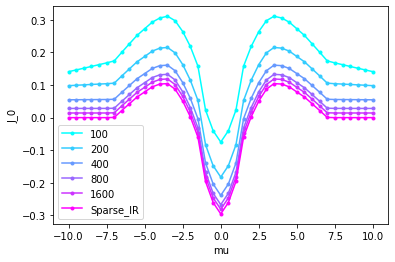

In [5]:
plt.xlabel("mu")
plt.ylabel("J_0")
for i, nm in enumerate([100, 200, 400, 800, 1600]):
      l.j0_calc(e_range=np.linspace(-10,10,41), NM=nm)
      plt.plot(l.j0_e_range, l.j0, marker='.', label=str(nm), color=cm.cool(i/5.))
l.j0_calc(e_range=np.linspace(-10,10,41))
plt.plot(l.j0_e_range, l.j0, marker='.', label='Sparse_IR', color=cm.cool(1.0))
plt.legend()
plt.show()

As is expected, the system favors the antiferromagnetic state at the half-filling while it favors the ferromagnetic state at the low-carrier regime. This feature is consistent with the super-exchange and the doule-exchange interactions.

#### Executing the solver for J_ij
We can also evaluate J_ij by using jij_calc function as follows.

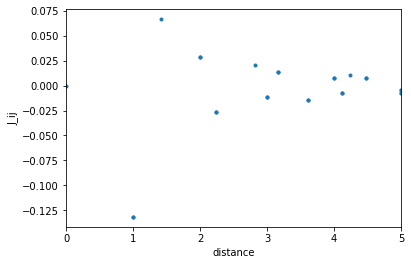

In [6]:
plt.clf
plt.xlabel("distance")
plt.ylabel("J_ij")
plt.xlim([0,5])
l.jij_calc(0)
plt.scatter(l.jij_r, l.jij, marker='.')
plt.show()

We can easily check $J_0=\sum_j J_{0j}$ as follows.

In [7]:
J0_1 = l.j0[20]   # J0 at mu=0 evaluated by j0_calc
J0_2 = sum(l.jij)  
print(J0_1,J0_2)

-0.29545913777987787 -0.29545913808706603


[1] Liechtenstein et al., J. Phys. F: Met. Phys. 14 L125 (1984).